In [58]:
import json

from matplotlib import pyplot
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.warp import transform_bounds
from rasterio.windows import Window
from rasterio.crs import CRS

np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline

In [59]:
with open('filter.json') as f:
    filters = json.load(f)
    bbox = filters['bbox']

In [60]:
result = ! rio capella --credentials credentials.json --area filter.json --collection rotterdam-aerial --limit 10 query
fc = json.loads(result[0])
ft = fc['features'][0]

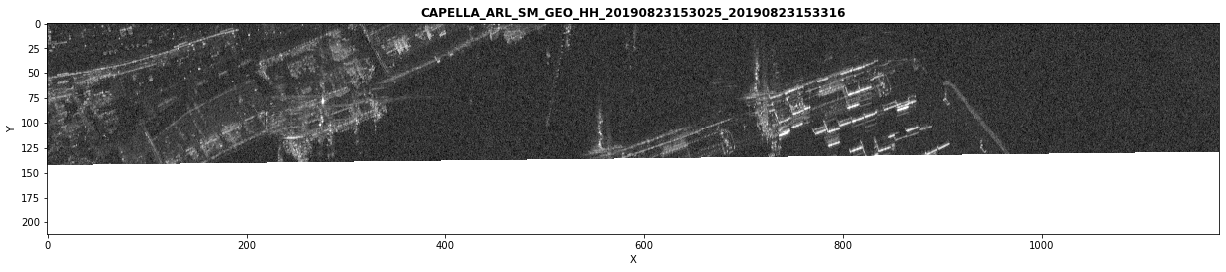

In [61]:
with rasterio.Env():
    # use first result feature id as an example
    fid =  f"tiledb://capellaspace/{ft['collection']}_{ft['id']}"

    with rasterio.open(fid) as src:        
        meta = src.meta
        tags = src.tags()
        
        native_bounds = transform_bounds(CRS.from_epsg(4326), src.crs, *bbox)        
        bounds_window = src.window(*native_bounds)
        bounds_window = bounds_window.intersection(Window(0, 0, src.width, src.height))
        
        img = src.read(1, window=bounds_window)

        img[img == meta['nodata']] = 0
        
        img_desc = json.loads(tags['TIFFTAG_IMAGEDESCRIPTION'])
        sf = img_desc['collect']['image']['scale_factor']
        
        scale = 1/float(sf)
        scl_img = img/scale
        
        db_img = 20*np.log10(scl_img)
        
        fig, ax = pyplot.subplots(1, 1, figsize=(21,7))
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        show(db_img, ax=ax, cmap='gray', title=ft['id'])
